# Asymptotic Formulae

**Goal:** I recently tried reading through [Asymptotic formulae for likeihood-based tests of new physics](https://arxiv.org/abs/1007.1727), and I wanted to work through the examples and reporduce their plots to make sure that I was understanding the concepts that were being discussed in the theory section of the paper.

In [1]:
import pyhf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from scipy import stats
from scipy.stats import norm

from tqdm import tqdm

## Ex 1: Counting experiment

Consider a cut-and-count analysis where in the signal region we have a (known) number of signal events (s), and our background is represented by a nuisance parameter b such that $\mathbb{E}[n] = \mu s + b$, and the nuisance parameter b is constrained in a control region such that $\mathbb{E}[m] = \tau b$.

$$\mathcal{L}(\mu,b) = \frac{\left( \mu s + b\right)^n}{n!} e^{-(\mu s +b)} \frac{(\tau b)^m}{m!} e^{- \tau b}$$

We can find the MLE and conditional MLE estimators analytically for this case, and then we can compare the asymptotic formula for $f(q_0 | 0)$ versus the distribution derived from throwing mc samples adn constructing a histogram.

In [2]:
mu_hat = lambda n,m,s,tau: (n - m/tau) / s

b_hat = lambda n,m,s,tau: m / tau

def b_hatHat(n,m,s,tau,mu): 
    
    a = 2*(1+tau)
    b = n+m-(1+tau)*mu*s
    c = mu*m*s
    
    return (b + np.sqrt(b**2 + 2*a*c)) / a
    

In [3]:
f_q0_0 = lambda q0: np.exp(-q0 / 2) / (2*np.sqrt(2*np.pi*q0))

In [4]:
def get_q0(ns, ms, s, b, tau):

    mu_hats = mu_hat(ns,ms,s,tau)
    b_hats = b_hat(ns,ms,s,tau)
    b_hatHats = b_hatHat(ns,ms,s,tau,0)
    
    # Get the Poisson pmf with scipy.stats.poisson
    L0 = stats.poisson.pmf(ns, b_hatHats) * stats.poisson.pmf(ms, tau*b_hatHats)
    Lmle = stats.poisson.pmf(ns,mu_hats*s + b_hats) * stats.poisson.pmf(ms,tau*b_hats)
     
    q0 = -2 * np.log(L0 / Lmle)
    
    '''
    For q0, we don't consider mu_hat < 0 incompatible with null hypo since
    we're assuming that the signal has a positive signal strength
    '''    
    if type(mu_hats) == float:
        q0 = q0 if mu_hats >= 0 else 0
    
    else:
        q0[mu_hats < 0] = 0
    
    return q0



In [5]:
def get_q0s(s,b,tau,mup,nsamples):
    
    ns = np.random.poisson(mup*s + b,nsamples)
    ms = np.random.poisson(tau*b,nsamples)

    return get_q0(ns, ms, s, b, tau)
    

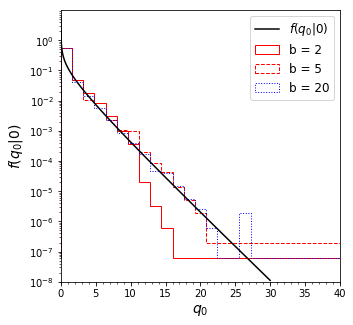

In [6]:
nsamples = int(1e6)
s = 10 # Just choose s = 10 for now, since this is what we need for Fig 3b anyways

# The paper just used one value of tau for all of their plots
tau = 1

nBins=25
myRange = (0,40)

eps = .001
q0 = np.linspace(eps,30,500)

fig,ax = plt.subplots(1,figsize=(5,5))

plt.semilogy(q0,f_q0_0(q0),'k-',label='$f(q_0 | 0)$')

for b, color, style in zip([2,5,20],['r','r','b'],['-','--',':']):
    
    q0 = get_q0s(s,b,tau,0,nsamples)
    
    plt.hist(q0,nBins,myRange,histtype='step',
             color=color,linestyle=style,
             log=True,density=True,
             label='b = {}'.format(b))
    
plt.xlabel('$q_0$',fontsize=14)
plt.ylabel('$f(q_0 | 0)$',fontsize=14)
plt.legend(fontsize=12)

plt.ylim(1e-8,10)
plt.xlim(0,40)

major_yticks = np.logspace(-8,0,9)
ax.set_yticks(major_yticks)

minor_yticks = np.concatenate([f*np.arange(2,10) for f in np.logspace(-8,0,9)])
ax.set_yticks(minor_yticks,minor=True)

ax.xaxis.set_major_locator(MultipleLocator(5))
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))

ax.xaxis.set_minor_locator(MultipleLocator(1))

plt.show()

*Note, at this point I don't think we had to use the Asimov dataset at all.*

Ok, so that's the distribution of the test statistic under the null hypothesis $\mu' = 0$ where there's *no signal*, we would want to use such a test statistic for discovery.

To see how such a test statistic would change if there were in fact a signal, we can also look at the pdf $f(q_0 | 1)$, and I think we would want such a pdf for signal injection tests.


In [7]:
f_q0_1 = lambda q0,mup,sigma: np.exp(-0.5*(np.sqrt(q0)-mup/sigma)**2) / (2*np.sqrt(2*np.pi*q0))

For this distribution, we need to make some assumption about the variance of $\hat{\mu}$ under the assumption that $\mu' = 1$, and the text said they determined this by using the Asimov value $q_{0,A}$.

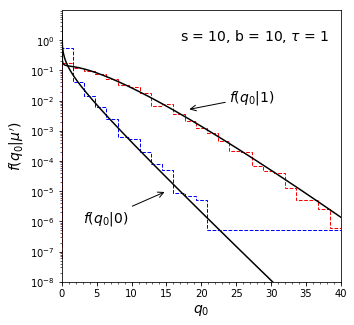

In [8]:
eps = .001
q0 = np.linspace(eps,40,500)

fig,ax = plt.subplots(1,figsize=(5,5))

plt.semilogy(q0,f_q0_0(q0),'k-') 

s,b = 10,10

'''
Ok, now I want to solve for the q0,A to get an estimate
for sigma of <mu> | mu'=1
'''
nA = s+b
mA = tau*b

q0A = get_q0(nA, mA, s, b, tau) 

sigma = 1 / np.sqrt(q0A)

plt.semilogy(q0,f_q0_1(q0,1,sigma),'k-') 

'''
MC result for f(q0 | 0)
'''
q0 = get_q0s(s,b,tau,0,nsamples)

plt.hist(q0,nBins,myRange,histtype='step',
         color='b',linestyle='--',
         log=True,density=True)
        
'''
MC result for f(q0 | 1)
'''
q0 = get_q0s(s, b, tau, 1, nsamples)

plt.hist(q0,nBins,myRange,histtype='step',
         color='r',linestyle='--',
         log=True,density=True)
    
plt.xlabel('$q_0$',fontsize=14)
plt.ylabel('$f(q_0 | \mu\')$',fontsize=14)

plt.ylim(1e-8,10)
plt.xlim(0,40)

major_yticks = np.logspace(-8,0,9)
ax.set_yticks(major_yticks)

minor_yticks = np.concatenate([f*np.arange(2,10) for f in np.logspace(-8,0,9)])
ax.set_yticks(minor_yticks,minor=True)

ax.xaxis.set_major_locator(MultipleLocator(5))
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))

ax.xaxis.set_minor_locator(MultipleLocator(1))

text = r's = {}, b = {}, $\tau$ = {}'.format(s,b,tau)
plt.text(17,1,text,fontsize=14)

'''
Include arrows on the plot
'''
ax.annotate('$f(q_0 | 0)$',xy=(15,1e-5),xytext=(3,1e-6),
            arrowprops=dict(arrowstyle="->"),fontsize=14)

ax.annotate('$f(q_0 | 1)$',xy=(18,.005),xytext=(24,.01),
            arrowprops=dict(arrowstyle="->"),fontsize=14)

plt.show()

### Discovery significance

8it [02:32, 13.06s/it] 


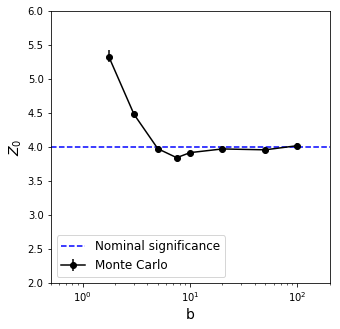

In [31]:
fig,ax = plt.subplots(1,figsize=(5,5))

sig = 4

xlim = [.5,200]
plt.semilogx(xlim,[sig]*2,'b--',label='Nominal significance')

'''
Find the exact versions of these formulas using MC
'''
ns = np.array([int(1e8),int(1e7)] + [int(2e6)]*6)
bs = np.array([1.75, 3, 5, 7.5, 10, 20, 50, 100])

ps = np.array([np.sum(get_q0s(s,b,tau,0,n) > sig**2) / n  \
               for b,n in tqdm(zip(bs,ns))])
    
zs = norm.ppf(1-ps)

dps = np.sqrt(ps*(1-ps)/ns)
Zdown = norm.ppf(1-ps-dps)
Zup   = norm.ppf(1-ps+dps)
 
Zerrs = np.vstack((zs-Zdown,Zup-zs))
    
plt.errorbar(bs,zs,yerr=Zerrs,color='k',marker='o',label='Monte Carlo')

plt.xlabel('b',fontsize=14)
plt.ylabel('$Z_0$',fontsize=14)
plt.legend(loc='lower left',fontsize=12)

plt.xlim(xlim)
plt.ylim(2,6)

plt.show()

**I'm so confused about these error bars!!!**

For the plot above, we have $\mu' = 0$, which means we're trying to determine the significance of observing $q_0 = 16$ when there isn't any signal.

In [32]:
Zerrs

array([[0.06757205, 0.03258352, 0.02694419, 0.02139369, 0.02435491,
        0.02678412, 0.02617421, 0.02915518],
       [0.10671364, 0.03817118, 0.03018194, 0.0233123 , 0.02692748,
        0.02997813, 0.02920476, 0.03303358]])

5it [00:00,  6.35it/s]


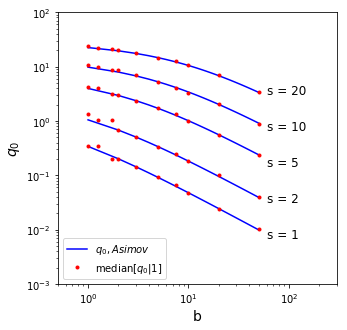

In [12]:
fig,ax = plt.subplots(1,figsize=(5,5))

bcont = np.linspace(1,50)

bs = [1,1.25,1.75,2,3,5,7.5,10,20,50]
n = 10000 

for s,ytext in tqdm(zip([1,2,5,10,20],np.logspace(-2.15,.5,5))):

    '''
    Draw the asymptotic curves
    '''
    label = '$q_0,Asimov$' if s == 1 else None
    
    nA = s + bcont
    mA = tau*bcont
    q0A = get_q0(nA, mA, s, bcont, tau) 
    
    plt.loglog(bcont, q0A, 'b',label=label)

    text = 's = {}'.format(s)
    plt.text(60,ytext,text,fontsize=12)
     
    '''
    Find the exact versions of these formulas using MC
    '''
    med_q0_1 = [np.sort(get_q0s(s,b,tau,1,n))[int(n/2)] for b in bs]    
    label = 'median[$q_0|1$]' if s == 1 else None
    plt.loglog(bs,med_q0_1,'r.',label=label)
        
plt.xlabel('b',fontsize=14)
plt.ylabel('$q_0$',fontsize=14)
plt.legend(loc='lower left')

plt.xlim(.5,300)
plt.ylim(.001,100)

plt.show()

Next, we want to flip the question around and look at the distribution of $q_1$ (used for setting an upper limt) for various hypotheses about whether or not we actually have a signal.

In [13]:
def get_qmu(ns, ms, s, b, tau, mu):

    mu_hats = mu_hat(ns,ms,s,tau)
    b_hats = b_hat(ns,ms,s,tau)
    b_hatHats = b_hatHat(ns,ms,s,tau,mu)
    
    # Get the Poisson pmf with scipy.stats.poisson
    Lmu = stats.poisson.pmf(ns,mu*s + b_hatHats) * stats.poisson.pmf(ms,tau*b_hatHats)
    Lmle = stats.poisson.pmf(ns,mu_hats*s + b_hats) * stats.poisson.pmf(ms,tau*b_hats)
    
    qmu = -2 * np.log(Lmu / Lmle)
        
    if type(mu_hats) == float:
        qmu = qmu if mu_hats <= mu else 0
    
    else:
        qmu[mu_hats > mu] = 0
    
    return qmu


In [14]:
def get_qmus(s,b,tau,mu,mup,nsamples):
    
    ns = np.random.poisson(mup*s + b,nsamples)
    ms = np.random.poisson(tau*b,nsamples)

    return get_qmu(ns, ms, s, b, tau, mu)
    

In [15]:
def f_qmu_mup(qmu,mu,mup,sigma): 
    
    x = (mu - mup)/sigma
    
    return np.exp(-0.5*(np.sqrt(qmu)-x)**2) / (2*np.sqrt(2*np.pi*qmu))


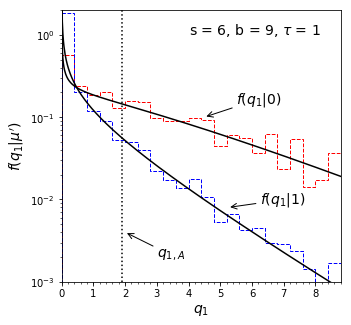

In [16]:
s, b = 6, 9

nBins=22
myRange=(0,8.8)

eps = .001
q1 = np.linspace(eps,myRange[1],500)

fig,ax = plt.subplots(1,figsize=(5,5))

# Get q1A | mu' = 0
nA = b
mA = tau*b

q1A = get_qmu(nA, mA, s, b, tau, 1) 
sigma = 1 / np.sqrt(q1A)

plt.semilogy(q1,f_qmu_mup(q1,1,1,sigma),'k-') 
plt.semilogy(q1,f_qmu_mup(q1,1,0,sigma),'k-') 

plt.plot([q1A]*2,[.001,2],'k:')

# MC results for f(q1 | mu')
for mup,c in zip([0,1],['r','b']):

    q1_dist = get_qmus(s,b,tau,1,mup,nsamples)
    plt.hist(q1_dist,nBins,myRange,histtype='step',
             color=c,linestyle='--',
             log=True,density=True)

plt.xlabel('$q_1$',fontsize=14)
plt.ylabel('$f(q_1 | \mu\')$',fontsize=14)

plt.xlim(myRange)
plt.ylim(.001,2)

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))

ax.xaxis.set_minor_locator(MultipleLocator(0.2))

text = r's = {}, b = {}, $\tau$ = {}'.format(s,b,tau)
plt.text(4,1,text,fontsize=14)

'''
Include arrows on the plot
'''
ax.annotate('$f(q_1 | 0)$',xy=(4.5,.1),xytext=(5.5,.15),
            arrowprops=dict(arrowstyle="->"),fontsize=14)

ax.annotate('$f(q_1 | 1)$',xy=(5.25,.008),xytext=(6.25,.009),
            arrowprops=dict(arrowstyle="->"),fontsize=14)

ax.annotate('$q_{1,A}$',xy=(2,.004),xytext=(3,.002),
            arrowprops=dict(arrowstyle="->"),fontsize=14)

plt.show()


We can also combine this upper limit statistic with the statistic that we use for positive strength signals to get $\tilde{q}_\mu$. 

In [17]:
def get_qtilde(ns, ms, s, b, tau, mu):

    mu_hats = mu_hat(ns,ms,s,tau)
    b_hats = b_hat(ns,ms,s,tau)
    b_hatHats = b_hatHat(ns,ms,s,tau,mu)
    
    # Get the Poisson pmf with scipy.stats.poisson
    Lmu = stats.poisson.pmf(ns,mu*s + b_hatHats) * stats.poisson.pmf(ms,tau*b_hatHats)
    
    Lmle = stats.poisson.pmf(ns,mu_hats*s + b_hats) * stats.poisson.pmf(ms,tau*b_hats)
    
    b_hatHat0 = b_hatHat(ns,ms,s,tau,0)
    L0 = stats.poisson.pmf(ns,b_hatHat0) * stats.poisson.pmf(ms,tau*b_hatHat0)
        
    if type(mu_hats) == float:
        
        if mu_hats < 0:
            qmu = -2 * np.log(Lmu / L0)
        elif mu_hats <= mu:
            qmu = -2 * np.log(Lmu / Lmle)
        else:
            qmu = 0
        
    else:
        
        qmu = -2 * np.log(Lmu / Lmle)
        
        qmu[mu_hats < 0] = -2 * np.log(Lmu / L0)[mu_hats < 0]
        qmu[mu_hats > mu] = 0
    
    return qmu


In [18]:
def get_qtildes(s,b,tau,mu,mup,nsamples):
    
    ns = np.random.poisson(mup*s + b,nsamples)
    ms = np.random.poisson(tau*b,nsamples)

    return get_qtilde(ns, ms, s, b, tau,mu)
    

In [19]:
def f_qtilde_mu_mup(q,mu,mup,sigma): 
    
    x = (mu - mup)/sigma 
    f = np.exp(-0.5*(np.sqrt(q)-x)**2) / (2*np.sqrt(2*np.pi*q))

    mask = (q > (mu/sigma)**2)
    fup = np.exp(-0.5*(q-(mu**2 - 2*mu*mup)/sigma**2)**2/(2*mu/sigma)**2) / (np.sqrt(2*np.pi)*2*mu/sigma)
    f[mask] = fup[mask]
    
    return f

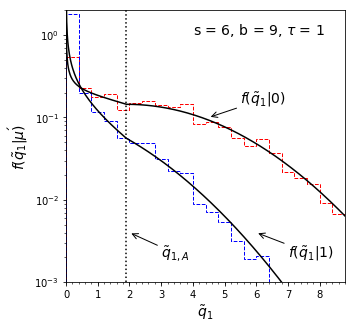

In [20]:
s, b = 6, 9

fig,ax = plt.subplots(1,figsize=(5,5))

# Get q1A | mu' = 0
nA = b
mA = tau*b

q1tildeA = get_qtilde(nA, mA, s, b, tau, 1) 
sigma = 1 / np.sqrt(q1A)

plt.semilogy(q1,f_qtilde_mu_mup(q1,1,1,sigma),'k-') 
plt.semilogy(q1,f_qtilde_mu_mup(q1,1,0,sigma),'k-') 

plt.plot([q1tildeA]*2,[.001,2],'k:')

# MC results for f(q1 | mu')
for mup,c in zip([0,1],['r','b']):

    q1_dist = get_qtildes(s,b,tau,1,mup,nsamples)
    plt.hist(q1_dist,nBins,myRange,histtype='step',
             color=c,linestyle='--',
             log=True,density=True)

plt.xlabel(r'$\tilde{q}_1$',fontsize=14)
plt.ylabel(r'$f(\tilde{q}_1 | \mu\')$',fontsize=14)

plt.xlim(myRange)
plt.ylim(.001,2)

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))

ax.xaxis.set_minor_locator(MultipleLocator(0.2))

text = r's = {}, b = {}, $\tau$ = {}'.format(s,b,tau)
plt.text(4,1,text,fontsize=14)

'''
Include arrows on the plot
'''
ax.annotate(r'$f(\tilde{q}_1 | 0)$',xy=(4.5,.1),xytext=(5.5,.15),
            arrowprops=dict(arrowstyle="->"),fontsize=14)

ax.annotate(r'$f(\tilde{q}_1 | 1)$',xy=(6,.004),xytext=(7,.002),
            arrowprops=dict(arrowstyle="->"),fontsize=14)

ax.annotate(r'$\tilde{q}_{1,A}$',xy=(2,.004),xytext=(3,.002),
            arrowprops=dict(arrowstyle="->"),fontsize=14)

plt.show()


In [21]:
print('q1A = {:.4f}, q1tildeA = {:.4f}'.format(q1A,q1tildeA))

q1A = 1.9026, q1tildeA = 1.9026


It makes sense that the Asimov values stayed the same, because for the $\mu' = 0$ hypothesis, we have 

$n_A = b$
$m_A = \tau b$

so the MLE estimator for $\hat{\mu} = 0$, and that means there's no difference in the $q_{1,A}$ and $\tilde{q}_{1,A}$ test statistics.


In [22]:
mu_hat(nA,mA,s,tau)

0.0

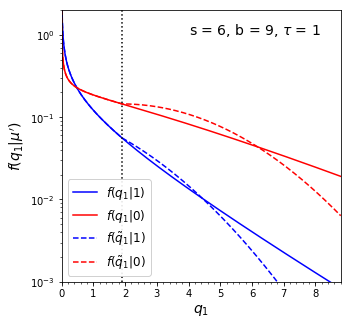

In [23]:
s, b = 6, 9

nBins=22
myRange=(0,8.8)

fig,ax = plt.subplots(1,figsize=(5,5))

plt.semilogy(q1,f_qmu_mup(q1,1,1,sigma),'b-',label=r'$f(q_1 | 1)$') 
plt.semilogy(q1,f_qmu_mup(q1,1,0,sigma),'r-',label=r'$f(q_1 | 0)$')

plt.semilogy(q1,f_qtilde_mu_mup(q1,1,1,sigma),'b--',label=r'$f(\tilde{q}_1 | 1)$') 
plt.semilogy(q1,f_qtilde_mu_mup(q1,1,0,sigma),'r--',label=r'$f(\tilde{q}_1 | 0)$') 

plt.plot([q1A]*2,[.001,2],'k:')

plt.xlabel(r'$q_1$',fontsize=14)
plt.ylabel(r"$f(q_1|\mu')$",fontsize=14)
plt.legend(loc='lower left',framealpha=.9,fontsize=12)

plt.xlim(myRange)
plt.ylim(.001,2)

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))

ax.xaxis.set_minor_locator(MultipleLocator(0.2))

text = r's = {}, b = {}, $\tau$ = {}'.format(s,b,tau)
plt.text(4,1,text,fontsize=14)

plt.show()


The Asimov test statistic stays the same, and it is the median of the distribution under the $\mu' = 0$ hypothesis.

**How does this translate into an understanding of which test statsitic is more powerful??**
- I would have thought that $q_1$ would be more powerful than $\tilde{q}_1$ if $\mu' = 1$
- But looking at this plot, it's not 100% clear to me that this is in fact the case.


Last test statistic for this example, let's look at $q = -2 \ln \frac{\mathcal{L}_{s+b}}{\mathcal{L}_b}$, which I believe is a variant of the test statistic that we're using for the 4b analysis rn.

0 -0.0
mu' = 1, sigma = -inf


/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: divide by zero encountered in double_scalars


-0.0 2.4277149876389785
mu' = 0, sigma = 0.6418021243476869


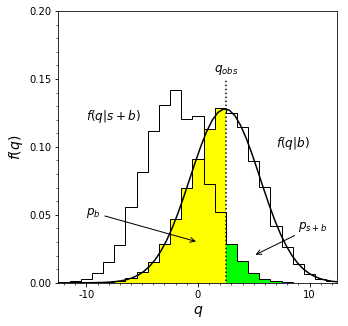

In [30]:
s, b = 10, 20

nBins=25
r=(-12.5,12.5)
ylim = (0,0.2)

fig,ax = plt.subplots(1,figsize=(5,5))

q = np.linspace(*r)

qobs = 2.5
plt.plot([qobs]*2,[.001,.15],'k:')
plt.text(qobs,.155,'$q_{obs}$',fontsize=12,ha='center')

'''
Let's get the mc samples
'''
for mup in [1,0]:
    
    ns = np.random.poisson(mup*s + b,nsamples)
    ms = np.random.poisson(tau*b,nsamples) 

    b0 = b_hatHat(ns,ms,s,tau,0)
    b1 = b_hatHat(ns,ms,s,tau,1)
    
    # Get the Poisson pmf with scipy.stats.poisson
    L0 = stats.poisson.pmf(ns, b0) * stats.poisson.pmf(ms, tau*b0)
    L1 = stats.poisson.pmf(ns, s+b1) * stats.poisson.pmf(ms, tau*b1)

    q_dist = -2 * np.log(L1 / L0)
      
    plt.hist(q_dist,nBins,r,color='k',
             histtype='step',density=True,zorder=1)   
        
    m = (q_dist<qobs) if mup == 0 else (q_dist>qobs)
    c = 'yellow' if mup == 0 else 'lime'
                
    ni = np.sum(m)
    ws = np.ones(ni)/nsamples

    plt.hist(q_dist[m],nBins,r,color=c,
             histtype='bar',weights=ws,zorder=0)
       
    '''
    We also want to overlay the functional form for the 
    test statistic q, and to do this we can get the stdev
    sigma using the Asimov dataset.
    '''
    nA = mup*s + b
    mA = tau*b

    '''
    Or, do I use mu' for the last arg???
    '''
    q0A = get_qmu(nA, mA, s, b, tau, 0) 
    q1A = get_qmu(nA, mA, s, b, tau, 1) 
    
    print(q0A,q1A)
    
    '''
    But, I'm confused, b/c I would have thought that sigma
    depended on the choice of mu as well, see eq (30).
    '''
    sigma = 1 / np.sqrt(q1A)
    
    print("mu' = {}, sigma = {}".format(mup,sigma))
    
    mean = (1 - 2*mup) / sigma**2
    sd = 2/sigma
        
    f = norm.pdf(q,loc=mean,scale=sd)
        
    plt.plot(q,f,'k')
        
plt.xlabel(r'$q$',fontsize=14)
plt.ylabel("$f(q)$",fontsize=14)

plt.xlim(r)
plt.ylim(ylim)

ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.xaxis.set_minor_locator(MultipleLocator(1))

ax.yaxis.set_major_locator(MultipleLocator(.05))
ax.yaxis.set_minor_locator(MultipleLocator(0.01))


'''
Add annotations to the plot
'''
plt.text(-10,.12,'$f(q|s+b)$',fontsize=12)
plt.text(7,.1,'$f(q|b)$',fontsize=12)

plt.annotate('$p_b$',xy=(0,.03),xytext=(-10,.05),
             arrowprops=dict(arrowstyle="->"),fontsize=12)
plt.annotate('$p_{s+b}$',xy=(5,.02),xytext=(9,.04),
             arrowprops=dict(arrowstyle="->"),fontsize=12)

plt.show()


**Note: the functional form for f(q|s+b) is clearly wrong, but I was confused about how to get $\sigma_A$ from the Asimov dataset anyways, so it's definitely best to ask Micahel at this point!**

**Question: How do you get the $s/\sqrt{b}$ term to pop out of eq (97)?**

Next, in the absence of systematic uncertainties, compare Asimov formula with an exact calculation and the more commonly used $s/\sqrt{b}$ formula. 

For the exact calculcation, since there's no $\tau any more$, the get_q0 formula simplifies quite a bit to reflect the simpler likelihood function that we have now.


In [25]:
def q0s(s,b,mup,nsamples):
    
    ns = np.random.poisson(mup*s + b,nsamples)

    muHats = (ns-b)/s
    
    q0 = 2*(ns*np.log(ns/b) + b - ns)
    q0[muHats < 0] = 0 
    
    return q0

  0%|          | 0/3 [00:00<?, ?it/s]/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in multiply
  import sys
100%|██████████| 3/3 [00:52<00:00, 17.08s/it]


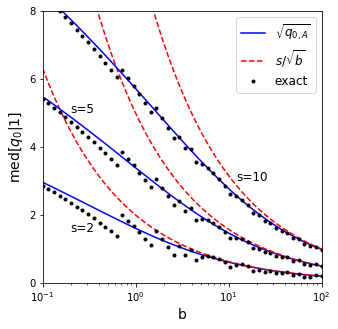

In [26]:
fig,ax = plt.subplots(1,figsize=(5,5))

b = np.logspace(-1,2)
n = int(2e5)

for s in tqdm([2,5,10]):
    
    q0A = np.sqrt(2*((s+b)*np.log(1+s/b)-s))
    plt.semilogx(b,q0A,'b-',
                 label='$\sqrt{q_{0,A}}$' if s == 2 else None)
        
    plt.semilogx(b,s/np.sqrt(b),'r--',
                 label='$s/\sqrt{b}$' if s == 2 else None)
       
    med_q0_1 = [np.sort(q0s(s,bi,1,nsamples))[int(nsamples/2)] for bi in b]
    plt.semilogx(b,np.sqrt(med_q0_1),'k.',
                 label='exact' if s == 2 else None)
        
plt.xlabel('b',fontsize=14)
plt.ylabel("med[$q_0$|1]",fontsize=14)
plt.legend(loc='upper right',fontsize=12)

plt.xlim(.1,100)
plt.ylim(0,8)

ax.yaxis.set_major_locator(MultipleLocator(2))

'''
Add annotations to the plot
'''
plt.text(.2,1.5,'s=2',fontsize=12)
plt.text(.2,5,'s=5',fontsize=12)
plt.text(12,3,'s=10',fontsize=12)

plt.show()

# Ex 2: Shape analysis

Consider a bump hunt in an invariant mass distribution where the background shape is assumped to be known and taken to be the *Rayleigh distribution*.

The pdf for the Rayleigh distribution is given by one free parameter $\sigma$:

$$f(x;\sigma) = \frac{x}{\sigma^2}e^{-x^2/(2\sigma^2)}, x \geq 0.$$

I believe $x$ should be interpretted as the invariant mass, and the \sigma was not specified in the text, but I guess I could play with it a bit to try to get the Figures to roughly match.


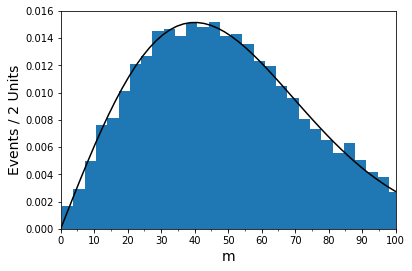

In [27]:
scale = 40

nBins = 50
myRange = (0,100)

m = np.linspace(*myRange)
f = stats.rayleigh.pdf(m,scale=scale)

fig,ax = plt.subplots(1,figsize=(6,4))

plt.plot(m,f,'k-')

xs = np.random.rayleigh(scale,10000)
plt.hist(xs,nBins,density=True)

plt.xlabel('m',fontsize=14)
plt.ylabel('Events / 2 Units',fontsize=14)

plt.xlim(myRange)

ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(MultipleLocator(5))

plt.show()

I'm not really sure what Fig 8 is plotting though...

In [28]:
(100-68.26)/2

15.869999999999997